# 1. Overview

We will be exploring the public data set that Google BigQuery has provided us. In particular we will be looking at the 2018 Yellow Taxi trips and the weather data set together. The variables from the weather data set are self explanatory from if you look at the field field names. The taxi data set however have some fields that are not immediately obvious in terms of their meaning, so the following are the detailed description of the fields associated with the taxi data set:
* **vendor_id**:	A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc
* **pickup_datetime**: The date and time when the meter was engaged.
* **dropoff_datetime**: The date and time when the meter was disengaged
* **passenger_count**: The number of passengers in the vehicle. This is a driver-entered value
* **trip_distance**: The elapsed trip distance in miles reported by the taximeter.
* **rate_code**: The final rate code in effect at the end of the trip. 1= Standard rate 2=JFK 3=Newark 4=Nassau or Westchester 5=Negotiated fare 6=Group ride
* **store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip N= not a store and forward trip
* **payment_type**:	A numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided trip
* **fare_amount**: The time-and-distance fare calculated by the meter
* extra	Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges.
* **mta_tax**: \$0.50 MTA tax that is automatically triggered based on the metered rate in use
* **tip_amount**:	Tip amount – This field is automatically populated for credit card tips. Cash tips are not included
* **tolls_amount**:	Total amount of all tolls paid in trip.
* **imp_surcharge**:	\$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
* **total_amount**:	The total amount charged to passengers. Does not include cash tips
* **pickup_location_id**: TLC Taxi Zone in which the taximeter was engaged
* **dropoff_location_id**: TLC Taxi Zone in which the taximeter was disengaged

# 2. Getting Started

In [1]:
# Imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

from pyspark.sql import SQLContext
from pyspark.sql import types
from pyspark.sql.functions import isnan, when, count, col

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Initialize Spark
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [116]:
# Get data from BigQuery and store it into Cloud Storage as GZIP compressed .csv files
!bq --location=US extract --compression GZIP 'bigquery-public-data:new_york_taxi_trips.tlc_yellow_trips_2018' gs://ajk-portfolio/data/nyc_taxi_trips/nyc_taxi_2018-*.csv.gz
!bq --location=US extract --compression GZIP 'bigquery-public-data:new_york_taxi_trips.taxi_zone_geom' gs://ajk-portfolio/data/nyc_taxi_trips/nyc_taxi_zones-*.csv.gz
!bq --location=US extract --compression GZIP 'bigquery-public-data:noaa_gsod.stations' gs://ajk-portfolio/data/nyc_weather/noaa_stations-*.csv.gz
!bq --location=US extract --compression GZIP 'bigquery-public-data:noaa_gsod.gsod2018' gs://ajk-portfolio/data/nyc_weather/noaa_weather-*.csv.gz

Waiting on bqjob_r5ae5d0098852883d_00000169b23015d0_1 ... (85s) Current status: DONE   


In [3]:
# Load data into Spark DataFrame
trips_df = spark.read \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .csv("gs://ajk-portfolio/data/nyc_taxi_trips/nyc_taxi_2018-*.csv.gz")

loc_df = spark.read \
              .option("header", "true") \
              .option("inferSchema", "true") \
              .csv("gs://ajk-portfolio/data/nyc_taxi_trips/nyc_taxi_zones-*.csv.gz")

stations_df = spark.read \
                   .option("header", "true") \
                   .option("inferSchema", "true") \
                   .csv("gs://ajk-portfolio/data/nyc_weather/noaa_stations-*.csv.gz")

weather_df = spark.read \
                  .option("header", "true") \
                  .option("inferSchema", "true") \
                  .csv("gs://ajk-portfolio/data/nyc_weather/noaa_weather-*.csv.gz")

In [4]:
# Print schemas of each DataFrame to ensure the data got loaded correctly correctly
trips_df.printSchema()
loc_df.printSchema()
stations_df.printSchema()
weather_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)

root
 |-- zone_id: integer (nullable = true)
 |-- zone_name: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- zone_geom: string (nullable = true)

root
 |-- usaf: string (nullable = true)
 |-- wban: integ

In [4]:
# register temp table so it can be queried with SQL
trips_df.registerTempTable("trips")
loc_df.registerTempTable("taxi_locations")
stations_df.registerTempTable("weather_stations")
weather_df.registerTempTable("weather")

In [5]:
# Join in all the loaded DataFrames into one
query = """
WITH daily_weather AS
    (SELECT
        TO_DATE(CAST(UNIX_TIMESTAMP(CONCAT(w.mo,'/',w.da,'/',w.year), 'MM/dd/yyyy') AS TIMESTAMP)) AS weather_date,
        w.temp AS avg_temp,
        w.max AS max_temp,
        w.min AS min_temp,
        w.prcp AS percip_inch,
        IF(w.sndp = 999.9, 0, w.sndp) AS snow_depth,
        w.fog,
        w.rain_drizzle,
        w.snow_ice_pellets,
        w.hail,
        w.thunder,
        w.tornado_funnel_cloud,
        w.wdsp AS wind_speed,
        w.dewp,
        w.visib
    FROM
        weather w
    WHERE 
        w.wban IN 
            (SELECT
                ws.wban
            FROM 
                weather_stations ws
            WHERE
                ws.country = 'US'
                AND ws.state = 'NY'
                AND ws.call = 'KNYC')),
yellow_trips AS 
    (SELECT
        t.vendor_id,
        TO_DATE(t.pickup_datetime) AS pickup_date,
        t.pickup_datetime,
        TO_DATE(t.dropoff_datetime) AS dropoff_date,
        t.dropoff_datetime,
        t.passenger_count,
        t.trip_distance,
        t.rate_code,
        t.store_and_fwd_flag, 
        t.payment_type,
        t.fare_amount,
        t.extra, 
        t.mta_tax, 
        t.tip_amount, 
        t.tolls_amount, 
        t.imp_surcharge,
        t.total_amount, 
        t.pickup_location_id, 
        ptl.borough AS pickup_borough,
        ptl.zone_name AS pickup_zone,
        t.dropoff_location_id,
        dtl.borough AS dropoff_borough,
        dtl.zone_name AS dropoff_zone
    FROM
        trips t
    LEFT JOIN
        taxi_locations ptl
        ON 
            ptl.zone_id = t.pickup_location_id
    LEFT JOIN
        taxi_locations dtl
        ON
            dtl.zone_id = t.dropoff_location_id)
SELECT 
    yt.vendor_id,
    yt.pickup_date,
    yt.pickup_datetime,
    yt.dropoff_date,
    yt.dropoff_datetime,
    yt.passenger_count,
    yt.trip_distance,
    yt.rate_code,
    yt.store_and_fwd_flag,
    yt.payment_type,
    yt.fare_amount,
    yt.extra,
    yt.mta_tax,
    yt.tip_amount,
    yt.tolls_amount,
    yt.imp_surcharge,
    yt.total_amount,
    yt.pickup_location_id,
    yt.pickup_borough,
    yt.pickup_zone,
    yt.dropoff_location_id,
    yt.dropoff_borough,
    yt.dropoff_zone,
    dw.avg_temp,
    dw.max_temp,
    dw.min_temp,
    dw.percip_inch,
    dw.snow_depth,
    dw.fog,
    dw.rain_drizzle,
    dw.snow_ice_pellets,
    dw.hail,
    dw.thunder,
    dw.tornado_funnel_cloud,
    dw.wind_speed,
    dw.dewp,
    dw.visib
FROM 
    yellow_trips yt
LEFT JOIN
    daily_weather dw
    ON 
        dw.weather_date = yt.pickup_date
"""

# create a new DataFrame based on the query
combo_df = spark.sql(query)

# Register the new DataFrame so that we can do EDA
combo_df.registerTempTable("combo")

# 3. Data Quality Check

For the sake of brevity, I am not including the various steps I took for data quality check that was done prior to doing data analysis. However, the following are the summary of some of the important findings:
* There are a handful of records where the `total_amount` paid for the is less than 0 or exceeds \$100,000. This does not make a lot of sense given the data set, and seems to likely be caused by erroneous data entry. 
* There are few records where the `trip_distance` is either 0 or greater than 100,000 miles. the 0 miles travelled may be due to cancelled trips, while the ones where over 100,000 miles is traveled are likely caused by erroneous entries.
* There are records where the `passenger_count` have odd values: 0 or greater than 100. Since this value is entered by taxi drivers, the 0s may be instances where the driver did not enter any value, and the ones over 100 may be erroneous entries.
* The data set also seems to be incomplete, as there are data from odd years (e.g. 1989) and the trips are mainly from January-June 2018. There also seems to be only less than 200 trips for July 2018 - December 2018.

The problematic records above are all removed prior to any subsequent analysis done as part of this notebook. In total 43K records were removed out of 63 million+ that the dataset contains.


In [6]:
# Filtering out problematic data
query = """
SELECT
    *
FROM
    combo c
WHERE 
    c.total_amount < 10000
    AND c.total_amount > 0
    AND c.trip_distance < 1000
    AND c.passenger_count < 100
    AND c.pickup_date >= '2018-01-01'
    AND c.pickup_date < '2018-07-01'
"""
# create a new DataFrame based on the query
combo_df = spark.sql(query)

# Re-register the new DataFrame so that we can do EDA based on the clean data
combo_df.registerTempTable("combo")

# 4. Exploratory Data Analysis

* There seems to be records where the total amount exceeds $100,000, which does not make a lot of sense. Likely these records will have to be removed prior to any modelling work.
* There seems to be a few issues with the `trip_distance` variables as there are instances where the logged value is 0 or greater than 100,000 miles. These are likely to be erroneous values and will be removed from the DataFrame
* There seems to be

### How has the number of trips change over time?

The number of trips seems to spike up significantly for the month of March, almost more than double the typical day on any other month. Currently I have no good explanation why there is such a big spike for the trip count in March, but this definitely needs to be explored further. Also there seems to be seasonality in the data, as the trip count tends to be higher during the weekday. There also seems to be a slight downward trend in trip count after April 2018.

In [206]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    ROUND(COUNT(*)/1000, 2) AS trip_count_k
FROM
    combo c
GROUP BY
    c.pickup_date,
    day_of_week
"""

start = time.time()
pd_df = spark.sql(query).toPandas()
print(f"... completed job in {time.time() - start} seconds")

... completed job in 107.19791269302368 seconds


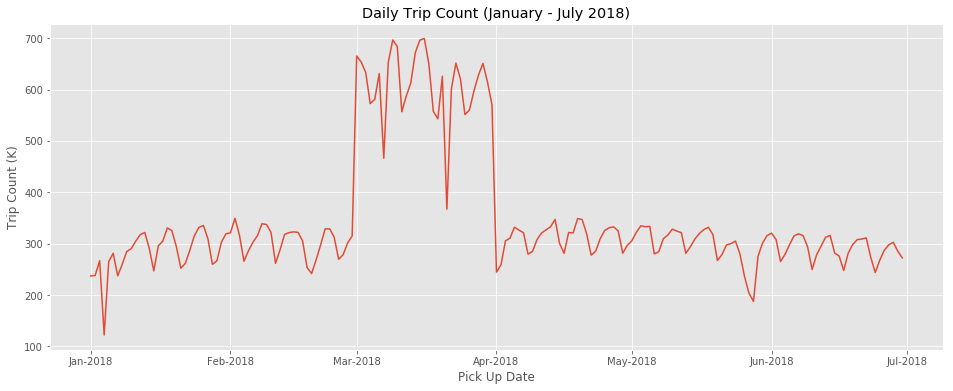

In [212]:
# Plot out the daily trip count
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x='pickup_date', y='trip_count_k', data=pd_df)

ax.set_title("Daily Trip Count (January - July 2018)")
ax.set_ylabel("Trip Count (K)")
ax.set_xlabel("Pick Up Date")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

plt.show()

### How does taxi usage differ by day?

We are using median here for the trip count by weekday since there is a large spike in trip count in March. The median trip count should give us what the typical trip count is for each day of the week. After plotting out the trip count, it looks like the number of trips tend to be slightly higher on weekdays, indicating perhaps people tend to use taxi as means of commuting to and from work.


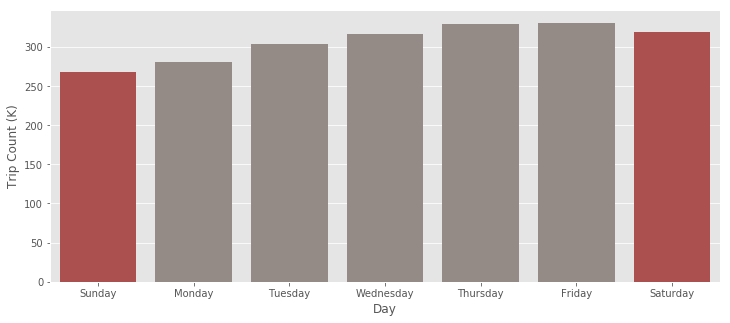

In [9]:
# aggregate by day of the week
data = pd_df.groupby("day_of_week").trip_count_k.median().to_frame().reset_index()

# indicator for weekend vs. weekday so we can color it differently in the plot.
data["weekend_ind"] = data.day_of_week.apply(lambda x: 1 if (x == "Saturday" or x == "Sunday") else 0)
data["sort_dow"] = data["day_of_week"].replace({"Sunday":0, 
                                                "Monday":1,
                                                "Tuesday":2,
                                                "Wednesday":3,
                                                "Thursday":4,
                                                "Friday": 5,
                                                "Saturday":6})

# sort the pd datfarame so that it shows up nicely in the plot
data.sort_values(by="sort_dow", inplace=True)

# plot out the weekday median trip counts
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="day_of_week",
            y="trip_count_k",
            palette=["#978a84", "#bb3f3f"],
            data=data,
            hue="weekend_ind",
            dodge=False, ax=ax)

# remove legend and change labels
ax.get_legend().remove()
ax.set_ylabel("Trip Count (K)")
ax.set_xlabel("Day")

# show the plot!
plt.show()

### How does taxi usage differ by time of the day?

When examining the trip counts by time of day between weekend and weekdays, the differences
between the two clearly indicate that taxi is used both for work and play. On weekdays we see a pattern of increased usage during the morning and afternoon rush hour. On Weekends, trip counts does not really see an increase in the morning as most people are not utilizing it for their work commute. However, on weekends, the trip counts increase starting around lunch time, and late into the evening and into the early morning. This is likely because people are using Taxi to go out. 

One other observation is that people tend to travel longer distances in early morning (around 5-6 AM). One possible explanation for this is that perhaps the taxi riders at this time are all heading to the airport in order to catch an early morning flight.

Lastly in terms of travel speed it seems that early morning trips are the fastest, particularly around 5-6 AM. On weekdays the travel speed seems to sharply slow down around 8 AM, most likely due to rush hour traffic, and it continues to be rather slow until 5 PM. On weekends on the other hand, it seems that the slow down occur at a slower rate than weekdays. This is likely because on weekends there there are not as much traffic since most people are not working.

In [112]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    HOUR(c.pickup_datetime) AS pickup_time,
    ROUND(COUNT(*)/1000, 2) AS trip_count_k,
    MEAN(c.trip_distance) AS mean_trip_distance,
    ROUND(MEAN((unix_timestamp(c.dropoff_datetime) - unix_timestamp(c.pickup_datetime))/60),
          2) AS mean_traveltime_min,
    ROUND(MEAN(c.trip_distance/((unix_timestamp(c.dropoff_datetime) - unix_timestamp(c.pickup_datetime))/3600)),
               2) AS mean_travelspeed_mph
FROM
    combo c
GROUP BY
    c.pickup_date,
    day_of_week,
    pickup_time
"""

start = time.time()
pd_df = spark.sql(query).toPandas()
print(f"... completed job in {time.time() - start} seconds")

... completed job in 138.19014406204224 seconds


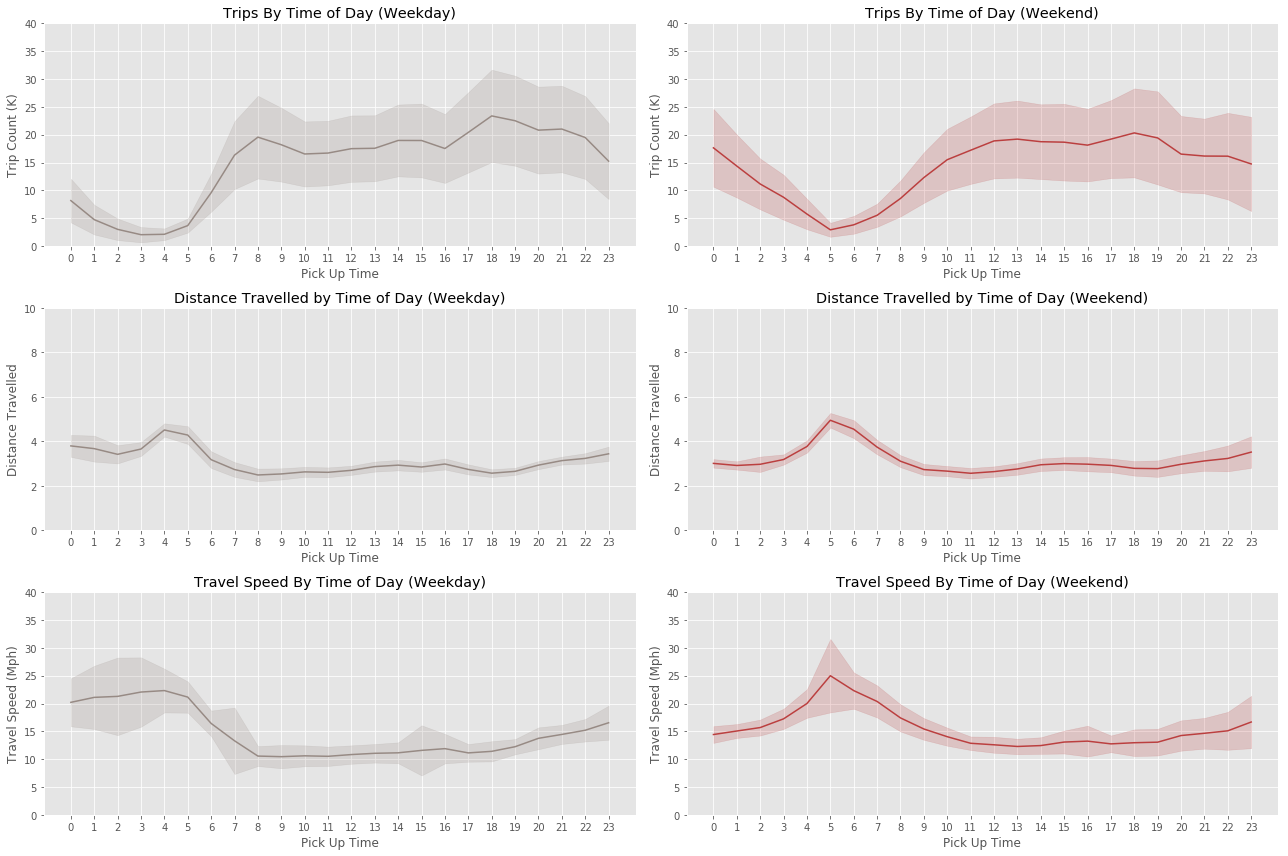

In [128]:
# indicator for weekend vs. weekday so we can color it differently in the plot.
pd_df["weekend_ind"] = pd_df.day_of_week.apply(lambda x: 1 if (x == "Saturday" or x == "Sunday") else 0)

# initialize a 2x2 plot
fig, ax = plt.subplots(3, 2, figsize=(18,12))

# color for weekend and weekdays
c = ["#978a84", "#bb3f3f"]

# the y axis values we're plotting
y = ["trip_count_k", "mean_trip_distance", "mean_travelspeed_mph"]

# y axis ranges and labels
ylim = np.array([[0,40], [0,10], [0,40]])
ylab = np.array(["Trip Count (K)", "Distance Travelled", "Travel Speed (Mph)"])

# titles for our plots
titles = np.array([["Trips By Time of Day (Weekday)", "Trips By Time of Day (Weekend)"],
                   ["Distance Travelled by Time of Day (Weekday)", "Distance Travelled by Time of Day (Weekend)"],
                   ["Travel Speed By Time of Day (Weekday)", "Travel Speed By Time of Day (Weekend)"]])

# iterate through each axis and assign the appropriate plot 
for a in np.arange(len(y)):
    for b in pd_df["weekend_ind"].unique():
        sns.lineplot(x="pickup_time",
                     y=y[a],
                     ci="sd",
                     data=pd_df[pd_df["weekend_ind"] == b],
                     color=c[b],
                     ax=ax[a, b])
        
        ax[a, b].set_title(titles[a, b])
        ax[a, b].set_xlabel("Pick Up Time")
        ax[a, b].set_ylabel(ylab[a]) 
        ax[a, b].set(xticks=np.arange(0,24))
        ax[a, b].set(ylim=ylim[a])
        
# Show the plot!        
plt.tight_layout()
plt.show()

### How does the weather affect trips?

It looks like the number of trips gets really low when it is really cold outside (below freezing). However other than that, it looks like the trip counts does not really vary that much with Temperature. This finding is rather surprising since I would expect that the trip count to be lower when it is warmer out as people may be more willing to walk to get around. 

Similarly, it does not look like that rain affects the trip count that much either as shown in the scatterplot below. Again, this is surprising since I would expect people to utilize Taxi more when it's raining out as they are less likely to walk. Perhaps a possible explanation is that people will call ride sharing services such as Uber or Lyft instead when it is raining out, since that does not require them to be outside in order to hail a taxi down.

In [198]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    MEAN(c.avg_temp) AS mean_temp,
    MEAN(c.percip_inch) AS mean_percip_inch,
    ROUND(COUNT(*)/1000, 2) AS trip_count_k
FROM
    combo c
GROUP BY
    c.pickup_date,
    day_of_week
"""

start = time.time()
pd_df = spark.sql(query).toPandas()
print(f"... completed job in {time.time() - start} seconds")

... completed job in 98.43696808815002 seconds


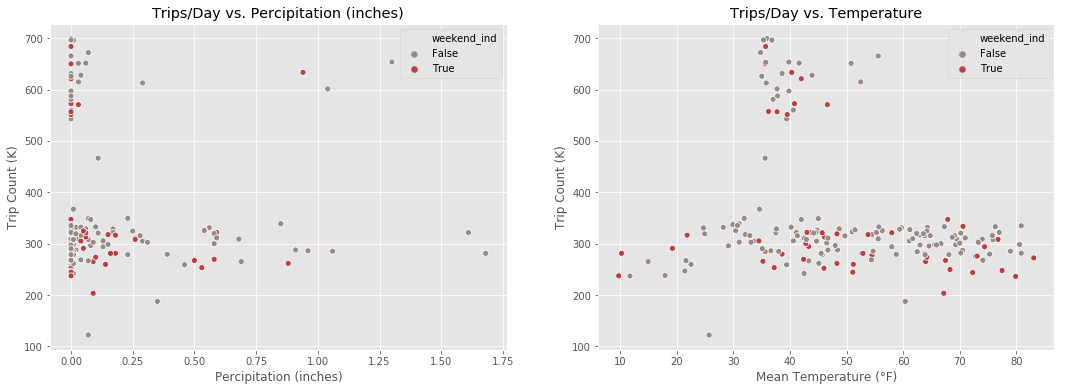

In [205]:
# Indicator for weekend vs. weekday so we can color it differently in the plot.
pd_df["weekend_ind"] = pd_df.day_of_week.apply(lambda x: True if (x == "Saturday" or x == "Sunday") else False)

# Initialize a 1x2 plot for our scatterplot
fig, ax = plt.subplots(1, 2, figsize=(18,6))

# Scatterplot for trip count/day vs. percipitation 
sns.scatterplot(x="mean_percip_inch", 
                y="trip_count_k",
                palette=["#978a84", "#bb3f3f"],
                hue="weekend_ind",
                data=pd_df, ax=ax[0])

# Change axis labels for the trip count/day vs. percipitation scatterplot
ax[0].set_ylabel("Trip Count (K)")
ax[0].set_xlabel("Percipitation (inches)")
ax[0].set_title("Trips/Day vs. Percipitation (inches)")

# Scatterplot for trip count/day vs. temperature
sns.scatterplot(x="mean_temp",
                y="trip_count_k",
                palette=["#978a84", "#bb3f3f"],
                hue="weekend_ind",
                data=pd_df, 
                ax=ax[1])

# change axis labels and title
ax[1].set_ylabel("Trip Count (K)")
ax[1].set_xlabel("Mean Temperature (°F)")
ax[1].set_title("Trips/Day vs. Temperature")

# Show the plot!
plt.show()

### What payment methods are popular?

In [15]:
query = """
SELECT
    CASE WHEN c.payment_type = 1 THEN "Credit Card"
         WHEN c.payment_type = 2 THEN "Cash"
         WHEN c.payment_type = 3 THEN "No Charge"
         WHEN c.payment_type = 4 THEN "Dispute"
         WHEN c.payment_type = 5 THEN "Unknown"
         WHEN c.payment_type = 6 THEN "Voided Trip" 
         END AS payment_type,
    COUNT(*) AS trip_count,
    0 AS pct_total_trip_count,
    ROUND(MEAN(c.fare_amount), 2) AS mean_fare_amount,
    ROUND(STD(c.fare_amount), 2) AS stdev_fare_amount
FROM
    combo c
GROUP BY 
    payment_type
"""

start = time.time()
pd_df = spark.sql(query).toPandas()
pd_df['pct_total_trip_count'] = round((pd_df['trip_count']*100)/count, 2)
print(f"... completed job in {time.time() - start} seconds")
pd_df.sort_values(by='trip_count', ascending=False)

... completed job in 50.529290437698364 seconds


,payment_type,trip_count,pct_total_trip_count,mean_fare_amount,stdev_fare_amount
0,Credit Card,44131674,69.68,13.22,11.73
3,Cash,18806396,29.70,11.70,11.22
1,No Charge,311721,0.49,13.36,36.10
2,Dispute,80699,0.13,14.16,18.46


### What are the top trip destinations? and where are those trips coming from?
Below is a results table that contain the top 4 destinations along with the top 5 origin for each of the 4 destinations. It seems that the top destination and the pick up location mainly occur in Manhattan, which is a bit surprising since Yellow taxis are able to pick up passengers in any of the 5 boroughs in New York. Perhaps one explanation for this is because Green taxis can only pick up passengers in the outer boroughs and northern part of Manhattan, so the Yellow taxis would have more competition if they operate outside of Manhattan, hence the Yellow taxis primarily operate in Manhattan.

In [130]:
query = """
WITH top_destination_origin AS 
    (SELECT
        CONCAT(c.dropoff_borough, ": ", c.dropoff_zone) AS dropoff_location,
        CONCAT(c.pickup_borough, ": ", c.pickup_zone) AS pickup_location,
        COUNT(*)/1000 AS trip_count_k,
        AVG(c.trip_distance) AS avg_trip_distance,
        AVG(c.passenger_count) AS avg_passenger_count,
        AVG(c.fare_amount) AS avg_fare_amount,
        DENSE_RANK() OVER(PARTITION BY CONCAT(c.dropoff_borough, ": ", c.dropoff_zone) 
                          ORDER BY COUNT(*) DESC) AS trip_count_rank
    FROM
        combo c
    GROUP BY
        dropoff_location,
        pickup_location),
top_destination AS 
    (SELECT
        CONCAT(c.dropoff_borough, ": ", c.dropoff_zone) AS dropoff_location,
        DENSE_RANK() OVER(ORDER BY COUNT(*) DESC) AS trip_count_rank,
        COUNT(*)/1000 AS trip_count_k
    FROM 
        combo c
    GROUP BY
        dropoff_location)
SELECT
    tdo.dropoff_location,
    tdo.pickup_location,
    tdo.trip_count_k,
    tdo.avg_trip_distance,
    tdo.avg_passenger_count,
    tdo.avg_fare_amount
FROM 
    top_destination td
INNER JOIN 
    top_destination_origin tdo
    ON 
        tdo.dropoff_location= td.dropoff_location
WHERE
    td.trip_count_rank IN (1, 2, 3, 4) 
    AND tdo.trip_count_rank IN (1, 2, 3, 4, 5)
ORDER BY
    td.trip_count_rank,
    tdo.trip_count_rank
"""

start = time.time()
pd_df = spark.sql(query).toPandas()
print(f"... completed job in {time.time() - start} seconds")

... completed job in 139.40312719345093 seconds


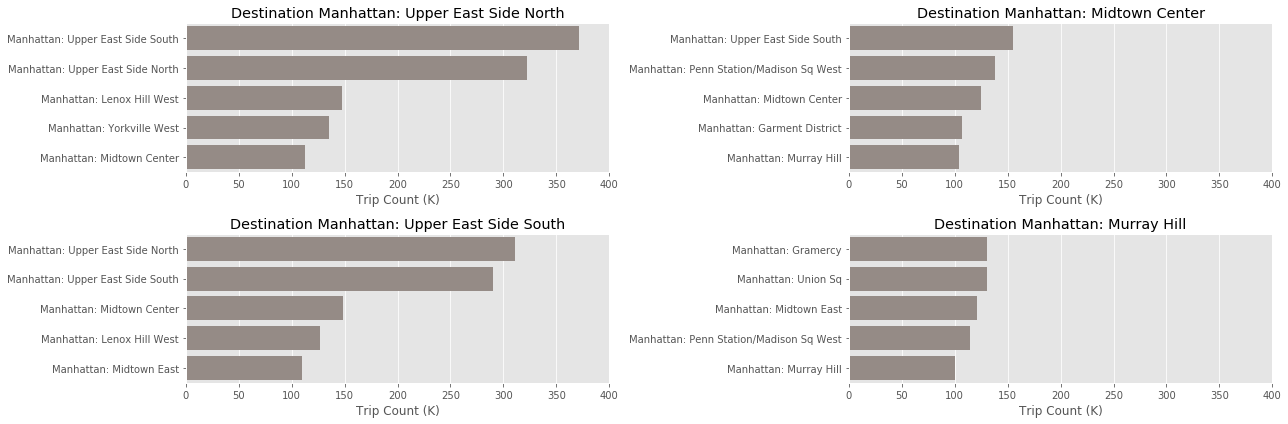

In [196]:
# initialize a 2x2 plot
fig, ax = plt.subplots(2, 2, figsize=(18,6))

# iterate through each axis and assign the appropriate plot 
for d in enumerate(pd_df["dropoff_location"].unique()):
    sns.barplot(x="trip_count_k",
                y="pickup_location",
                data=pd_df[pd_df["dropoff_location"] == d[1]],
                color="#978a84",
                ax=ax[d[0]//2, d[0]%2])
    
    # change axis labels and title
    ax[d[0] // 2, d[0] % 2].set_ylabel("")
    ax[d[0] // 2, d[0] % 2].set_xlabel("Trip Count (K)")
    ax[d[0] // 2, d[0] % 2].set_xlim([0,400])
    ax[d[0] // 2, d[0] % 2].set_title("Destination " + d[1])
    
plt.tight_layout()    
plt.show()

# 5. Models

In [ ]:
# TODO predicting travel times
# TODO predicting total tip
# TODO pickup dropoff location web graph

# 6. Conclusion

In [ ]:
# TODO